These are systems with a contact Hamiltonian of the form
$$
H = ps + f(q)s + F(q, t)
$$

We will focus in particular on the Van der Pol oscillator
where $f(q) = - \epsilon (1-q^2)$ and $F(q) = q - \phi(t)$.

In [1]:
from integrators import contact as ic
from integrators.common import rk4

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def D(system, dt,p,q,s,t):
    t += dt
    return p,q,s,t

def C(system, dt,p,q,s,t):
    q += s*dt
    p /= 1. + p*dt
    return p,q,s,t 

def B(system, dt,p,q,s,t):
    p -= system.Vq(q, t)*dt
    s -= system.V(q, t)*dt
    return p,q,s,t

def A(system, dt,p,q,s,t):
    f_q = system.f(q)
    s *= np.exp(-dt*f_q)
    if np.abs(f_q) < np.finfo(float).eps:
        p -= system.fq(q)*s*dt
    else:
        p = (p + system.fq(q)*s/f_q)*np.exp(-dt*f_q)
    return p,q,s,t
    
def step1(system, dt, p, q, s, t):
    for ap,coeff in [(D,0.5), (C,0.5), (B,0.5), (A,1), (B,0.5), (C,0.5), (D,0.5)]:
        p, q, s, t = ap(system, dt*coeff,p,q,s,t)
    return p, q, s, t

def step2(system, dt, p, q, s, t):
    for ap,coeff in [(D,0.5), (A,0.5), (B,0.5), (C,1), (B,0.5), (A,0.5), (D,0.5)]:
        p, q, s, t = ap(system, dt*coeff,p,q,s,t)
    return p, q, s, t

def step6(system, dt, p, q, s, t, a=ic.a_six, stepper=step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

In [4]:
class Lienard:
    def __init__(self, f, fq, F, Fq):
        self.f = f
        self.fq = fq
        self.F = F
        self.Fq = Fq
    
    def f(self, q):
        return self.f(q)
    
    def fq(self, q):
        return self.fq(q)
    
    def V(self, q, t):
        return self.F(q, t)
    
    def Vq(self, q, t):
        return self.Fq(q, t)

In [5]:
def vanDerPol(epsilon, a, omega):
    
    def f(q):
        return -epsilon*(1 - q**2)
    def fq(q):
        return 2*epsilon*q
    def F(q, t):
        return q - a*np.cos(omega*t)
    def Fq(q, t):
        return 1
    
    return Lienard(f, fq, F, Fq)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


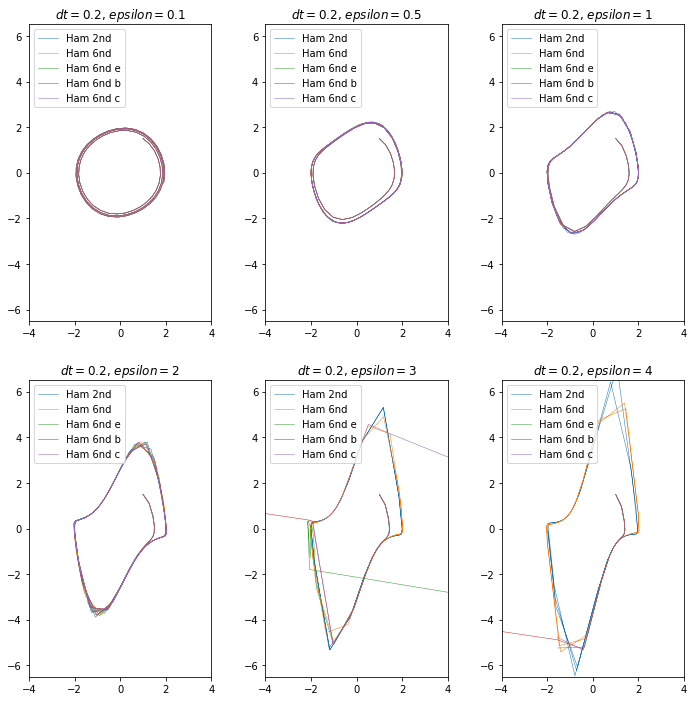

In [6]:
dt = 0.2
tf = 20
p0, q0, s0 = 0.0, 1.0, 1.5

tspan = np.linspace(0, tf, num=int(np.floor(tf/dt)))

plt.figure(figsize=(12,12))

for epsilon, spl in [(0.1, "231"), (0.5, "232"), (1, "233"), (2, "234"), (3, "235"), (4, "236")]:
    vdp = vanDerPol(epsilon, 0, 0)
    
    plt.subplot(spl)
    plt.title(f"$dt={dt}$, $epsilon={epsilon}$")

    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    solm, solms, _ = ic.integrate(step6, vdp, tspan, p0, q0, s0)
    #solrk = rk4(tpk, np.concatenate([p0,q0]), tspan)
    
    step6e = lambda system, dt, p, q, s, t: step6(system, dt, p, q, s, t, a=ic.e_six)
    step6b = lambda system, dt, p, q, s, t: step6(system, dt, p, q, s, t, a=ic.b_six)
    step6c = lambda system, dt, p, q, s, t: step6(system, dt, p, q, s, t, a=ic.c_six)
    sole, soles, _ = ic.integrate(step6e, vdp, tspan, p0, q0, s0)
    solb, solbs, _ = ic.integrate(step6b, vdp, tspan, p0, q0, s0)
    solc, solcs, _ = ic.integrate(step6c, vdp, tspan, p0, q0, s0)


    plt.plot(sol[:,1], sols,
             linewidth=0.5, label="Ham 2nd")
    plt.plot(solm[:,1], solms,
             linewidth=0.5, label="Ham 6nd")
    
    plt.plot(sole[:,1], soles,
             linewidth=0.5, label="Ham 6nd e")
    plt.plot(solb[:,1], solbs,
             linewidth=0.5, label="Ham 6nd b")
    plt.plot(solc[:,1], solcs,
             linewidth=0.5, label="Ham 6nd c")

    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlim((-4,4))
    plt.ylim((-6.5,6.5))

    plt.legend(loc='upper left')

plt.show()

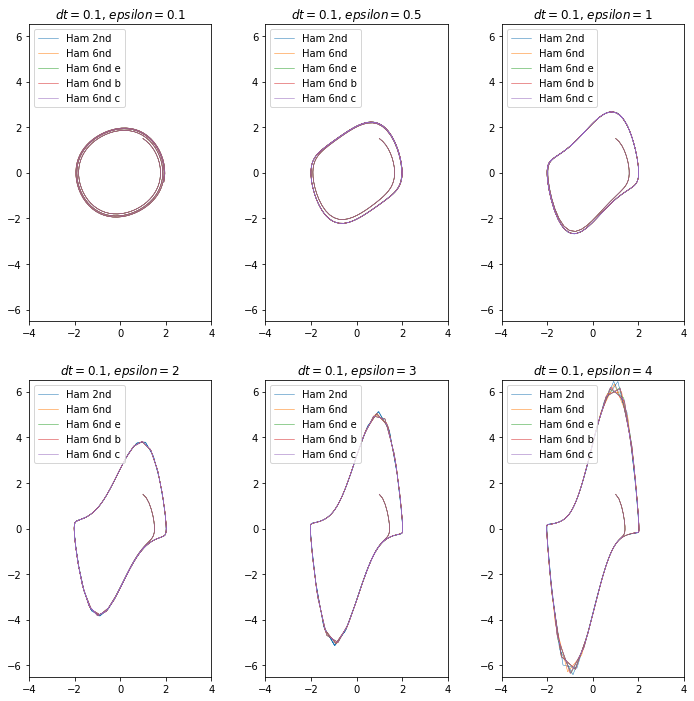

In [7]:
dt = 0.1
tf = 20
p0, q0, s0 = 0.0, 1.0, 1.5

tspan = np.linspace(0, tf, num=int(np.floor(tf/dt)))

plt.figure(figsize=(12,12))

for epsilon, spl in [(0.1, "231"), (0.5, "232"), (1, "233"), (2, "234"), (3, "235"), (4, "236")]:
    vdp = vanDerPol(epsilon, 0, 0)
    
    plt.subplot(spl)
    plt.title(f"$dt={dt}$, $epsilon={epsilon}$")

    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    solm, solms, _ = ic.integrate(step6, vdp, tspan, p0, q0, s0)
    #solrk = rk4(tpk, np.concatenate([p0,q0]), tspan)
    
    step6e = lambda system, dt, p, q, s, t: step6(system, dt, p, q, s, t, a=ic.e_six)
    step6b = lambda system, dt, p, q, s, t: step6(system, dt, p, q, s, t, a=ic.b_six)
    step6c = lambda system, dt, p, q, s, t: step6(system, dt, p, q, s, t, a=ic.c_six)
    sole, soles, _ = ic.integrate(step6e, vdp, tspan, p0, q0, s0)
    solb, solbs, _ = ic.integrate(step6b, vdp, tspan, p0, q0, s0)
    solc, solcs, _ = ic.integrate(step6c, vdp, tspan, p0, q0, s0)


    plt.plot(sol[:,1], sols,
             linewidth=0.5, label="Ham 2nd")
    plt.plot(solm[:,1], solms,
             linewidth=0.5, label="Ham 6nd")
    
    plt.plot(sole[:,1], soles,
             linewidth=0.5, label="Ham 6nd e")
    plt.plot(solb[:,1], solbs,
             linewidth=0.5, label="Ham 6nd b")
    plt.plot(solc[:,1], solcs,
             linewidth=0.5, label="Ham 6nd c")

    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlim((-4,4))
    plt.ylim((-6.5,6.5))

    plt.legend(loc='upper left')

plt.show()

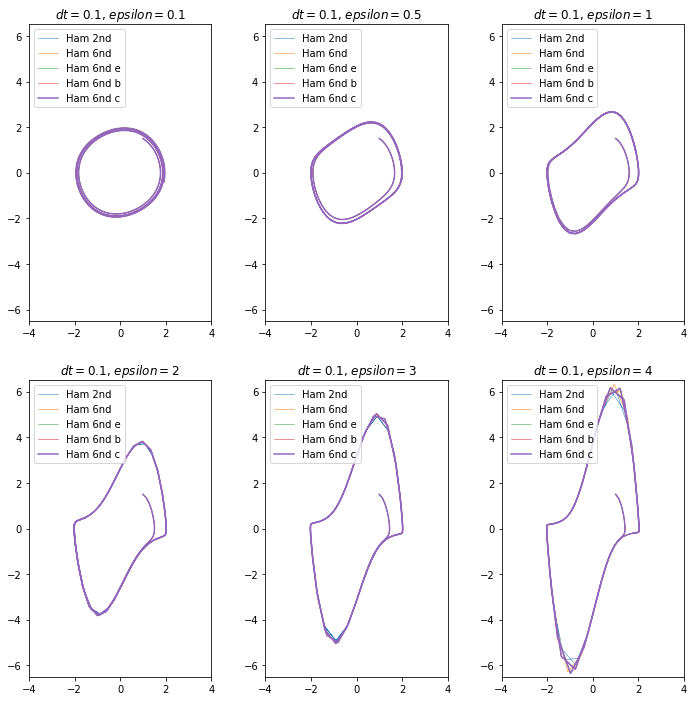

In [8]:
plt.figure(figsize=(12,12))

for epsilon, spl in [(0.1, "231"), (0.5, "232"), (1, "233"), (2, "234"), (3, "235"), (4, "236")]:
    vdp = vanDerPol(epsilon, 0, 0)
    
    plt.subplot(spl)
    plt.title(f"$dt={dt}$, $epsilon={epsilon}$")

    sol, sols, _ = ic.integrate(step2, vdp, tspan, p0, q0, s0)
    step62 = lambda system, dt, p, q, s, t: step6(system, dt, p, q, s, t, stepper=step2)
    step62e = lambda system, dt, p, q, s, t: step6(system, dt, p, q, s, t, stepper=step2, a=ic.e_six)
    step62b = lambda system, dt, p, q, s, t: step6(system, dt, p, q, s, t, stepper=step2, a=ic.b_six)
    step62c = lambda system, dt, p, q, s, t: step6(system, dt, p, q, s, t, stepper=step2, a=ic.c_six)

    solm, solms, _ = ic.integrate(step62, vdp, tspan, p0, q0, s0)
    sole, soles, _ = ic.integrate(step6e, vdp, tspan, p0, q0, s0)
    solb, solbs, _ = ic.integrate(step6b, vdp, tspan, p0, q0, s0)
    solc, solcs, _ = ic.integrate(step6c, vdp, tspan, p0, q0, s0)
    # solrk = rk4(tpk, np.concatenate([p0,q0]), tspan)

    plt.plot(sol[:,1], sols,
             linewidth=0.5, label="Ham 2nd")
    plt.plot(solm[:,1], solms,
             linewidth=0.5, label="Ham 6nd")
    
    plt.plot(sole[:,1], soles,
             linewidth=0.5, label="Ham 6nd e")
    plt.plot(solb[:,1], solbs,
             linewidth=0.5, label="Ham 6nd b")
    plt.plot(solc[:,1], solcs,
             label="Ham 6nd c")

    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlim((-4,4))
    plt.ylim((-6.5,6.5))

    plt.legend(loc='upper left')

plt.show()

In [9]:
# From P. Pihajoki:
# "Explicit methods in extendend phase space for inseparable Hamiltonian problems".
# Celest. Mech. Dyn. Astr. (2015)

In [10]:
from scipy import integrate as si

def err(x, y):
    errv = np.empty(len(x))
    for i in range(len(x)):
        errv[i] = max(errv[i-1] if i > 0 else 0, abs(x[i]-y[i]))
    return errv

In [11]:
def ivp_vdp(y, t, mu, a, omega):
    return [
        y[1],
        mu*(1-y[0]**2)*y[1] - y[0] + a*np.cos(omega*t)
    ]

# dt = 0.02
tout = np.linspace(0, 500, 25000)

y_init, params = [2, 2], (5, 5, 2.463)

y_odeint, info = si.odeint(ivp_vdp, y_init, tout, params, rtol=1e-13, atol=1e-15, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

# plt.figure(figsize=(14,10))
# plt.subplot("211")
# plt.plot(tout, y_odeint[:, 0], label='y')
# plt.plot(tout, y_odeint[:, 1], label='$\dot{y}$')
# plt.subplot("212")
# plt.plot(y_odeint[:, 0], y_odeint[:, 1])
# plt.xlabel("$x$")
# plt.ylabel("$\dot{x}$")
# plt.show()

Number of function evaluations: 261296, number of Jacobian evaluations: 3225


In [12]:
vdp = vanDerPol(5, 5, 2.463)
jump = 1
tout2 = np.linspace(0, 500, 25000*jump)


q0, s0 = 2, 2

sol, sols, _ = ic.integrate(step1, vdp, tout2, p0, q0, s0)
solm, solms, _ = ic.integrate(step6, vdp, tout2, p0, q0, s0)
sol2, sols2, _ = ic.integrate(step2, vdp, tout2, p0, q0, s0)
solm2, solms2, _ = ic.integrate(step62, vdp, tout2, p0, q0, s0)

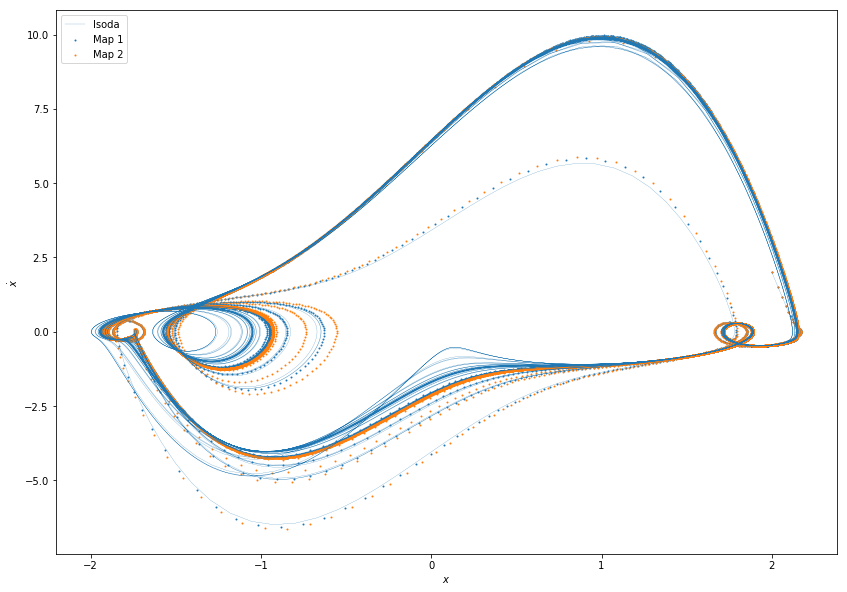

In [13]:
plt.figure(figsize=(14,10))
# plt.subplot("211")
# plt.plot(tout, sol[:,1][::jump], label="$x$")
# plt.plot(tout, sols[::jump], label="$\dot{x}$")
# plt.plot(tout, sol2[:,1][::jump], label="$x_2$")
# plt.plot(tout, sols2[::jump], label="$\dot{x}_2$")
# plt.legend(loc="upper left")
# plt.subplot("212")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], linewidth=0.2, label="lsoda")
plt.scatter(sol[:,1][::jump], sols[::jump], s=1, label="Map 1")
plt.scatter(sol2[:,1][::jump], sols2[::jump], s=1, label="Map 2")
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")
plt.legend(loc="upper left")
plt.show()

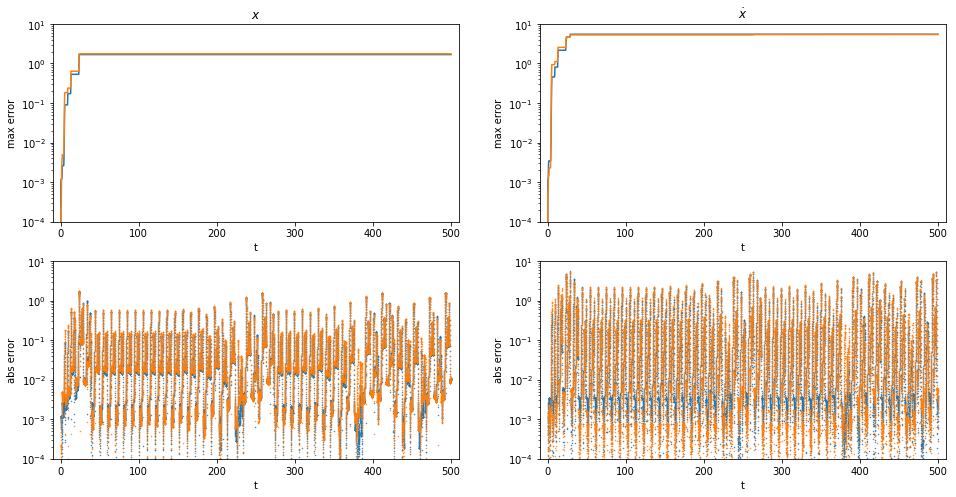

In [14]:
plt.figure(figsize=(16,8))

cut = 0
plt.subplot("221")
plt.title("$x$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tout[cut:],
         err(sol[:,1][cut::jump],y_odeint[cut:,0]))
plt.plot(tout[cut:],
         err(sol2[:,1][cut::jump],y_odeint[cut:,0]))
plt.yscale('log')
plt.xlim(-10,510)
plt.ylim(1e-4,10)

plt.subplot("222")
plt.title("$\dot{x}$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tout[cut:],
         err(sols[cut::jump],y_odeint[cut:,1]))
plt.plot(tout[cut:],
         err(sols2[cut::jump],y_odeint[cut:,1]))
plt.yscale('log')
plt.xlim(-10,510)
plt.ylim(1e-4,10)

# cut = 3000
# plt.subplot("223")
# plt.xlabel("t")
# plt.ylabel("max error")
# plt.plot(tout[cut:],
#          err(sol[:,1][cut::jump],y_odeint[cut:,0]))
# plt.yscale('log')
# plt.xlim(-10,510)
# plt.ylim(1e-4,10)

# cut = 3000
# plt.subplot("224")
# plt.xlabel("t")
# plt.ylabel("max error")
# plt.plot(tout[cut:],
#          err(sols[cut::jump],y_odeint[cut:,1]))
# plt.yscale('log')
# plt.xlim(-10,510)
# plt.ylim(1e-4,10)

plt.subplot("223")
plt.xlabel("t")
plt.ylabel("abs error")
plt.scatter(tout,
         abs(sol[:,1][::jump] - y_odeint[:,0]), s=0.2)
plt.scatter(tout,
         abs(sol2[:,1][::jump] - y_odeint[:,0]), s=0.2)
plt.yscale('log')
plt.ylim(1e-4,10)
plt.xlim(-10,510)

plt.subplot("224")
plt.xlabel("t")
plt.ylabel("abs error")
plt.scatter(tout,
         abs(sols[::jump] - y_odeint[:,1]), s=0.2)
plt.scatter(tout,
         abs(sols2[::jump] - y_odeint[:,1]), s=0.2)
plt.yscale('log')
plt.ylim(1e-4,10)
plt.xlim(-10,510)

plt.show()

In [15]:
# From Fangfang Jiang, Zhicheng Jim, Yan Wang: 
# "Qualitative Analysis of Crossing Limit Cycles in a Class of Discontinuous Liénard Systems with Symmetry"
# Qualitative Theory of Dynamical Systems, Volume 18, Issue 1 (2019)
 
def L1(epsilon):
    def f(q):
        if q >= 0:
            return epsilon*(q**2 - q)
        else:
            return epsilon*(q**2 + q)
        
    def fq(q):
        if q >= 0:
            return epsilon*(2*q - 1)
        else:
            return epsilon*(2*q + 1)

    def F(q, t):
        if q >= 0:
            return q+1
        else:
            return q-1
    
    def Fq(q, t):
        return 1
    
    return Lienard(f, fq, F, Fq)

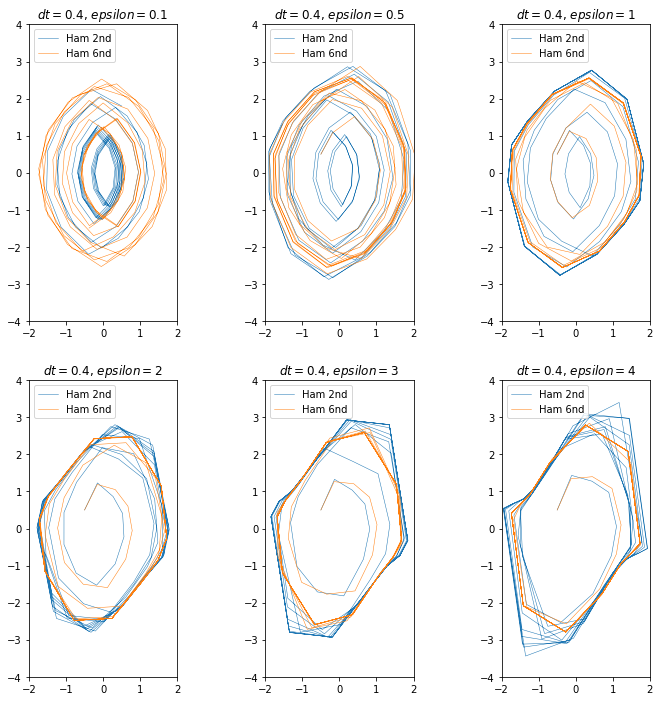

In [16]:
dt = 0.4
tf = 50
p0, q0, s0 = 0.0, -.5, 0.5

tspan = np.linspace(0, tf, num=int(np.floor(tf/dt)))

plt.figure(figsize=(12,12))

for epsilon, spl in [(0.1, "231"), (0.5, "232"), (1, "233"), (2, "234"), (3, "235"), (4, "236")]:
    l1 = L1(epsilon)
    
    plt.subplot(spl)
    plt.title(f"$dt={dt}$, $epsilon={epsilon}$")

    sol, sols, _ = ic.integrate(step1, l1, tspan, p0, q0, s0)
    solm, solms, _ = ic.integrate(step6, l1, tspan, p0, q0, s0)

    plt.plot(sol[:,1], sols,
             linewidth=0.5, label="Ham 2nd")
    plt.plot(solm[:,1], solms,
             linewidth=0.5, label="Ham 6nd")

    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlim((-2,2))
    plt.ylim((-4,4))

    plt.legend(loc='upper left')

plt.show()

In [17]:
# From: T. Harco, S. Liang:
# "Exact solutions of the Liénard- and generalized Liénard-type ordinary nonlinear differential equations obtained by deforming the phase space coordinates of the linear harmonic oscillator".
# Journal of Engineering Mathematics 98(1) (2015)

def explicit(n, beta, gamma, delta):
    def f(q):
        return -gamma*q + delta*q**n
        
    def fq(q):
        return -gamma + delta*n*q**(n-1)
    
    def F(q, t):
        return (beta-1)*q
    
    def Fq(q, t):
        return (beta-1)
    
    return Lienard(f, fq, F, Fq)

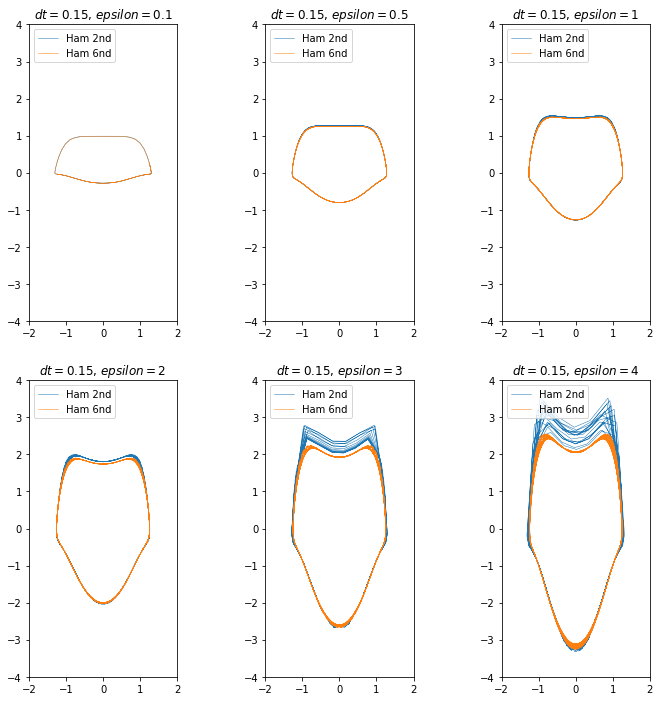

In [18]:
dt = 0.15
tf = 50
p0, q0, s0 = 0.0, 1.25, 0.25

tspan = np.linspace(0, tf, num=int(np.floor(tf/dt)))

plt.figure(figsize=(12,12))

for epsilon, spl in [(0.1, "231"), (0.5, "232"), (1, "233"), (2, "234"), (3, "235"), (4, "236")]:
    l1 = explicit(5, 1+epsilon, epsilon, 1+epsilon)
    
    plt.subplot(spl)
    plt.title(f"$dt={dt}$, $epsilon={epsilon}$")

    sol, sols, _ = ic.integrate(step1, l1, tspan, p0, q0, s0)
    solm, solms, _ = ic.integrate(step6, l1, tspan, p0, q0, s0)

    plt.plot(sol[:,1], sols,
             linewidth=0.5, label="Ham 2nd")
    plt.plot(solm[:,1], solms,
             linewidth=0.5, label="Ham 6nd")

    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlim((-2,2))
    plt.ylim((-4,4))

    plt.legend(loc='upper left')

plt.show()